<a href="https://colab.research.google.com/github/conglapgit45/Scene_Text_Recognition/blob/main/%5BState1%5D_STR_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Download data and import libraries

In [ ]:
# Download ICDAR 2003 dataset
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=f2bcd729-e08b-45f9-9f25-7e33b63a92e8
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 71.0MB/s]


In [ ]:
!pip install -q -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 24.2 MB/s eta 0:00:00


In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)


In [ ]:
!yolo predict model=yolo11n.pt source='https://ultralytics.com/images/bus.jpg'

100% 5.35M/5.35M [00:00<00:00, 65.6MB/s]
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 134k/134k [00:00<00:00, 6.05MB/s]
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 44.1ms
Speed: 11.1ms preprocess, 44.1ms inference, 716.2ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

import yaml
from sklearn.model_selection import train_test_split

# 2. Extract XML

In [ ]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [ ]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [ ]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


# 3. Convert to YOLO format

In [ ]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [ ]:
# Define class labels
class_labels = ["text"]    # only one class

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

# 4. Split data to Train, val, test

In [ ]:
seed = 45
val_size = 0.2
test_size = 0.125
is_shuffle = True

train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

# 5. Store data

In [ ]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [ ]:
save_yolo_data_dir = "/content/datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

# 6. Generate yaml file

In [ ]:
data_yaml = {
    "path": "/content/datasets/yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# 7. Train

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=150,
    imgsz=640,
    cache=True,
    patience=30,
    plots=True,
)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/datasets/yolo_data/data.yml, epochs=150, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /content/datasets/yolo_data/train/labels.cache... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 193.45it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 1 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 77.61it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       8.8G       1.95      2.972      1.772         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        224      0.626      0.679      0.637       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      8.74G      1.182      1.358      1.163         65        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        224      0.569      0.661      0.614      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      8.68G      1.189      1.359      1.174         49        640: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        224        0.1      0.402     0.0838     0.0462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      8.67G      1.258      1.213      1.208         71        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         43        224     0.0173      0.103    0.00752    0.00277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      8.75G      1.368      1.215      1.238         78        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         43        224     0.0114      0.179    0.00567    0.00157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      8.62G      1.393      1.149      1.278         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         43        224    0.00104     0.0357   0.000503   0.000106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      8.62G      1.342      1.174      1.224         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        224    0.00104     0.0357   0.000503   0.000106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      8.77G      1.384      1.191      1.243         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         43        224    0.00444     0.0402    0.00188   0.000412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      8.69G      1.278      1.173      1.193         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         43        224     0.0153     0.0357    0.00341    0.00144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      8.73G       1.29      1.046      1.212         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        224      0.289      0.281      0.149     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      8.64G      1.262      1.058      1.192         77        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         43        224      0.304      0.143     0.0962     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      8.68G      1.236      1.125      1.211         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         43        224      0.182      0.156     0.0619       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      8.69G      1.223      1.032       1.18         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         43        224      0.179      0.272     0.0949     0.0566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      8.78G      1.214     0.9278      1.165         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.271      0.228      0.121     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      8.67G      1.223     0.9519      1.162         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         43        224      0.445      0.314       0.24      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      8.67G      1.198     0.9399      1.153         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        224      0.579      0.518      0.518      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      8.69G      1.191     0.9459      1.156         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         43        224      0.508      0.443      0.426       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      8.73G      1.263      1.008      1.211         25        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.493      0.487      0.465      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      8.73G      1.123      0.907      1.132         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         43        224      0.654      0.683      0.633      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      8.78G      1.102     0.8759      1.131         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        224      0.717      0.691      0.715       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      8.64G      1.081     0.8626      1.105         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         43        224      0.646      0.636      0.646      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      8.69G      1.098     0.8569      1.122         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        224      0.692      0.696      0.692      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      8.65G      1.061      0.815      1.101         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         43        224      0.651      0.656      0.638      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      8.72G      1.071     0.8273      1.085        104        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.658      0.652      0.633      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      8.65G      1.112      0.831      1.101         69        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        224      0.638      0.707      0.677      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      8.74G     0.9973     0.8026      1.085         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        224      0.743      0.763      0.737      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      8.75G      1.045     0.8099      1.115         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         43        224      0.625       0.67      0.634      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      8.74G      1.049     0.8155      1.092         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.676      0.665      0.678       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      8.63G      1.009     0.8072      1.082         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         43        224      0.711      0.683      0.711       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      8.73G      1.042     0.7574      1.071         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        224      0.704      0.679      0.696       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      8.77G      1.001     0.7443      1.042         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         43        224      0.718      0.746      0.747      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      8.74G     0.9973     0.7515      1.081         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        224      0.763      0.719      0.737      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      8.68G     0.9952     0.7329      1.054         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         43        224      0.696      0.737      0.708      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      8.75G     0.9613     0.7037      1.036         89        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224      0.714      0.723      0.748      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      8.74G     0.9698     0.7764      1.071         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        224      0.776      0.786      0.793      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      8.72G      0.963     0.7326      1.057         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        224      0.792      0.656      0.712      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      8.62G     0.9226      0.709      1.037         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         43        224      0.716      0.692      0.724      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      8.78G     0.9651     0.7238      1.045         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         43        224      0.801      0.754       0.79       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      8.73G     0.9723     0.7142      1.043         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         43        224      0.801      0.759      0.799      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      8.69G     0.9803     0.7212      1.052         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        224      0.794      0.683      0.735      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      8.56G     0.9874     0.7036      1.066         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         43        224      0.805      0.739      0.779      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      8.75G     0.9648     0.6945       1.04         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         43        224      0.753      0.803      0.799      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      8.69G     0.8955     0.6689      1.032         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         43        224      0.793      0.812      0.804      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      8.69G      0.898     0.6771      1.045         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        224      0.709      0.746      0.752      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      8.64G     0.8981     0.6713      1.005         57        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        224      0.759      0.803      0.798      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      8.72G     0.9091     0.6563      1.015         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        224      0.758      0.777      0.761      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      8.77G      0.864     0.6315     0.9935         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         43        224      0.773      0.776      0.768      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150       8.6G     0.9067     0.6376      1.011         61        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224      0.772      0.786      0.774      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      8.55G     0.8829     0.6342     0.9846         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         43        224      0.818      0.821      0.796       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      8.74G     0.9143     0.6287       1.03         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        224      0.777      0.817      0.799      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      8.78G     0.8654     0.6544       1.03         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         43        224      0.774      0.797      0.812      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       8.7G     0.8569     0.6257     0.9864         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        224       0.85      0.737      0.793      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      8.62G     0.8659     0.6383      1.025         43        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


                   all         43        224      0.741      0.688      0.667      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      8.67G     0.8605     0.6551      1.003         74        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        224      0.773      0.777      0.766      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      8.75G     0.8827     0.6404      1.027         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         43        224      0.794      0.781      0.822      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      8.72G     0.8488     0.6232      1.016         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        224      0.758      0.782      0.766       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      8.69G     0.8861     0.6583      1.021         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        224      0.797      0.788      0.811      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      8.75G     0.8425     0.6369     0.9924         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         43        224      0.745      0.839      0.803      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150       8.6G     0.8698     0.6296      1.027         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        224      0.833      0.817      0.826      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      8.64G     0.8701     0.6431      1.021         66        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224      0.769      0.771      0.773      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      8.68G     0.8617     0.6362      1.018         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        224      0.826      0.765      0.812      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      8.68G     0.8634     0.6152     0.9914         60        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.817       0.75      0.805      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      8.69G     0.8771      0.607     0.9969         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         43        224      0.771      0.777      0.774      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      8.69G     0.8856     0.6362      1.016         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        224       0.82      0.817      0.839      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      8.69G     0.8359     0.6211     0.9987         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        224      0.827      0.795      0.808      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      8.77G     0.8226     0.5885     0.9821         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        224      0.832      0.866      0.845      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      8.75G     0.7826     0.5683     0.9892         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         43        224      0.794       0.81      0.803      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      8.74G     0.8175     0.5877     0.9726         38        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        224      0.799      0.853      0.823       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      8.73G     0.8256     0.5827     0.9866         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         43        224      0.849      0.852      0.848      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      8.76G     0.8073     0.5574     0.9886         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        224      0.845      0.857      0.842      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      8.69G     0.8151     0.5612     0.9899         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         43        224      0.856       0.82      0.846      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      8.74G     0.7645     0.5221       0.97         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.809      0.884      0.853      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      8.65G     0.8163     0.5563     0.9834         66        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         43        224      0.816      0.848      0.815      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      8.78G      0.774      0.558     0.9724         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224       0.78      0.837      0.824      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150       8.6G     0.7665     0.5338     0.9632         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


                   all         43        224      0.839      0.808      0.821      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      8.77G     0.7733      0.544     0.9779         86        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        224      0.811      0.824       0.83      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      8.72G     0.7811     0.5504     0.9606         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         43        224      0.835      0.816      0.828      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150       8.7G     0.7995     0.5359     0.9871         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.807      0.842      0.844      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      8.76G     0.7805     0.5398     0.9686         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         43        224      0.815      0.805      0.845       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      8.72G     0.7583     0.5139     0.9655         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224      0.851      0.848      0.862      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      8.62G     0.7636     0.5179     0.9659         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         43        224      0.821      0.884      0.868      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      8.69G     0.7296     0.5174     0.9541         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        224      0.845      0.844      0.851      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       8.7G     0.7456     0.4982     0.9538         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         43        224      0.826      0.848      0.843      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      8.69G     0.7488     0.5255     0.9551         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        224      0.799      0.799      0.826      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       8.7G     0.7125     0.4868     0.9498         58        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        224      0.762      0.855      0.835      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      8.74G     0.7308     0.5039     0.9462         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.813      0.817      0.838      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      8.74G     0.7514     0.4819     0.9484         84        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        224      0.841      0.804      0.833      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      8.63G       0.74      0.518     0.9528         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224       0.83      0.835      0.833      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      8.73G     0.7351     0.5023     0.9452         78        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


                   all         43        224      0.861      0.817      0.837      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      8.73G     0.7306     0.5138     0.9438         57        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         43        224       0.82      0.813      0.817      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      8.68G     0.7309     0.5131     0.9562         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         43        224      0.833      0.772      0.787      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      8.77G     0.7339     0.5213     0.9601         40        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.824      0.853      0.847      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      8.69G     0.7718     0.5249     0.9791         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         43        224      0.822      0.893      0.854      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      8.71G      0.723     0.5005     0.9657         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.826      0.846      0.855      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      8.77G      0.705     0.4972      0.948         59        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         43        224      0.806      0.851      0.859      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      8.68G      0.739     0.5015     0.9591         57        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         43        224      0.833      0.826      0.831      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      8.55G     0.7138     0.5077     0.9709         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        224      0.841      0.872      0.849      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      8.61G     0.7215     0.5156     0.9432         87        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        224      0.848      0.848      0.847      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       8.7G     0.7136     0.4956     0.9547         78        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         43        224      0.849      0.857      0.855      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       8.6G      0.675     0.4586     0.9352         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.849      0.854      0.858      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      8.72G     0.6677     0.4572     0.9433         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         43        224      0.832      0.821      0.834      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      8.69G     0.6935     0.4594     0.9261         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        224      0.838      0.805      0.825       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      8.73G     0.6762     0.4665     0.9401         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         43        224      0.818      0.844      0.825       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      8.74G     0.6973     0.4742     0.9528         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        224      0.827       0.79      0.819      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      8.63G     0.7038     0.5033     0.9365         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         43        224      0.851      0.793      0.815      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      8.76G     0.6915     0.4642      0.928         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         43        224      0.824      0.813      0.839      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      8.67G     0.6945      0.471     0.9343         79        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         43        224      0.849       0.79      0.854      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      8.73G     0.6684     0.4576     0.9379         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        224      0.848      0.812      0.862      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      8.72G      0.689     0.4732     0.9309         96        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         43        224      0.849      0.831      0.866      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      8.68G     0.7038     0.4604     0.9328         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        224      0.833      0.821      0.855      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      8.75G     0.6684     0.4677     0.9362         49        640: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         43        224      0.841      0.825      0.861      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       8.6G     0.6832     0.4466     0.9671         23        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.829      0.835      0.851       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      8.69G     0.6459     0.4406     0.9228         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         43        224      0.826      0.817      0.838      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      8.72G     0.6655     0.4433     0.9393         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        224      0.796      0.857      0.831      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      8.71G     0.6322      0.441      0.927         56        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         43        224      0.857      0.802      0.847      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      8.74G     0.6634     0.4454      0.928         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         43        224      0.824      0.834       0.85      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      8.69G     0.6495     0.4275     0.9232         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         43        224      0.806      0.835      0.858      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      8.63G     0.6543     0.4453      0.931         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        224      0.806      0.826       0.85      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      8.73G     0.6405     0.4327     0.9177         46        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.844      0.824      0.856      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      8.73G      0.655     0.4399     0.9297         67        640: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        224      0.833      0.848      0.866      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      8.67G     0.6503     0.4309     0.9145         65        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        224      0.831      0.839      0.869      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      8.72G     0.6391     0.4333     0.9294         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.858      0.812      0.868      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      8.68G     0.6593      0.439     0.9167         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        224      0.837      0.835      0.861      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      8.74G     0.6289     0.4249     0.9131         60        640: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         43        224      0.842      0.831      0.867      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      8.64G     0.6277     0.4223     0.9204         38        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         43        224      0.864      0.852      0.876      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      8.75G     0.6106     0.4244     0.9128         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         43        224      0.859      0.872      0.874       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      8.65G     0.6119     0.4126     0.9003         82        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.834      0.854      0.865       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      8.72G     0.5941     0.4036     0.9109         77        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        224      0.826      0.812      0.843      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      8.72G     0.5961     0.4083     0.9189         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         43        224      0.846      0.808       0.85      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      8.68G     0.6218     0.4043     0.8993         86        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         43        224      0.841      0.835      0.858      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      8.78G     0.6224     0.4094     0.9118        100        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        224      0.857      0.829      0.855      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      8.75G     0.6386     0.4284     0.9241         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         43        224      0.843       0.84      0.849      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      8.67G     0.6085     0.4166     0.9012         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.858      0.839       0.85      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       8.7G     0.6024     0.4045     0.9065         56        640: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         43        224       0.84      0.844      0.846      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      8.67G     0.5998     0.3996     0.8946         55        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         43        224      0.857       0.83      0.853      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      8.75G     0.5751     0.3991     0.9123         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         43        224      0.846      0.835      0.856       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      8.58G     0.5833      0.401     0.9054         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        224      0.845      0.848      0.858      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      8.67G     0.5922     0.3915     0.9018         73        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         43        224      0.872       0.83      0.859       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      8.78G     0.5731     0.3852     0.9074         32        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         43        224      0.876       0.83      0.859      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      8.78G     0.5633     0.3845     0.8996         39        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         43        224      0.868      0.812      0.856      0.657


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      8.64G     0.6291     0.4505     0.8961         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        224      0.868      0.817      0.858      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      8.72G     0.6213     0.4211      0.886         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         43        224       0.86      0.835      0.862      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      8.78G     0.6427     0.4418     0.8995         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        224      0.846      0.853      0.864      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      8.64G     0.5978     0.4024     0.8765         23        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


                   all         43        224      0.829      0.853      0.862      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      8.65G     0.5892      0.396     0.8683         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        224      0.838      0.844      0.863      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      8.68G     0.5873     0.3941     0.8671         48        640: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         43        224      0.818      0.862       0.86      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      8.69G     0.5977     0.4084     0.8754         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         43        224      0.829      0.844      0.858      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      8.74G      0.602     0.3917     0.8877         68        640: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         43        224      0.859      0.812      0.855      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      8.62G     0.6031     0.4056     0.8747         27        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         43        224      0.873      0.812      0.856      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      8.72G     0.6045     0.4008     0.8785         29        640: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         43        224      0.876      0.812      0.856      0.662



150 epochs completed in 0.399 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 40.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


                   all         43        224      0.859      0.871      0.874       0.68
Speed: 0.2ms preprocess, 9.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2


# 8. Evaluate the model

In [ ]:
from ultralytics import YOLO

model_path = "/content/runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 1 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


                   all         43        224      0.626      0.679      0.637      0.419
Speed: 0.6ms preprocess, 23.0ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val2


# 9. Inference

In [ ]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

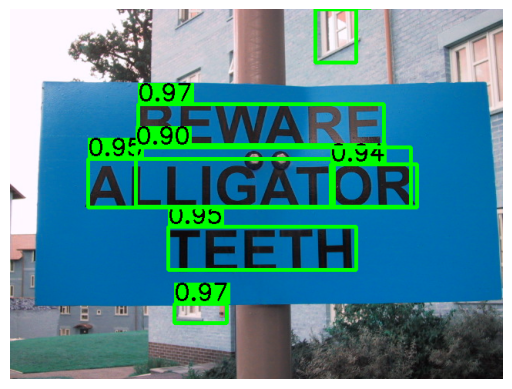

In [ ]:
from ultralytics import YOLO

model_path = "runs/detect/train/weights/best.pt"
img_path = "/content/datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2460.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()